In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.metrics import dtw, soft_dtw
from tslearn.utils import to_time_series_dataset
from sklearn.utils.validation import _check_large_sparse
from tslearn.clustering import TimeSeriesKMeans
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [59]:
persian_emoji_map = {'neutral': ['none'], 'smirk':['contempt'], 'furious':['furious'], 'weary':['annoyed'], 'expressionless':['none'], 'unamused': ['annoyed', 'contempt', 'disgust'], 'rollingeyes':['contempt'], 'none':['none'], 'skeptical':['none'], 'angry':['anger', 'annoyed','hatred'], 'nauseated':['disgust'], 'vomiting':['disgust'], 'triumph':['anger', 'hatred'], 'hatred':['hatred', 'anger', 'furious'], 'smilingimp': ['contempt']} 
na_emoji_map = {'neutral': ['none'], 'smirk':['contempt'], 'furious':['furious', 'anger'], 'weary':['disgust'], 'expressionless':['contempt','annoyed'], 'unamused': ['annoyed', 'contempt'], 'rollingeyes':['annoyed'], 'none':['none'], 'skeptical':['none'], 'angry':['anger', 'annoyed'], 'nauseated':['disgust'], 'vomiting':['disgust'], 'triumph':['anger'], 'hatred':['hatred', 'furious']}

In [66]:
X_df = pd.read_csv('../new_data/NA/na_dataset.csv', index_col=None)
Y_df = pd.read_csv('../new_data/NA/na_emoji_labels.csv', usecols=['filename', 'emoji'], index_col='filename')
emotion_df = pd.read_csv('../new_data/NA/na_labels.csv', usecols=['filename', 'emotions'], index_col='filename')

Y_df["emoji"] = Y_df["emoji"].apply(eval)
emotion_df["emotions"] = emotion_df["emotions"].apply(eval)
label_cols = to_1D(Y_df["emoji"]).unique() 
emotion_cols = to_1D(emotion_df["emotions"]).unique() 
# label_cols.append('smilingimp')
labels_expanded = boolean_df(Y_df['emoji'], label_cols )
emotions_expanded = boolean_df(emotion_df['emotions'], emotion_cols )



In [ ]:
emotion_cols

In [ ]:
labels_expanded.loc['na/vid_5.mp4']

In [ ]:
for l in label_cols:
    X_df[label_cols]  = np.NaN
    

In [ ]:
X_df.head()

In [ ]:
label_cols.tolist()

In [ ]:
print(labels_expanded.at['na/vid_5.mp4', 'hatred'])

In [67]:
for index, row in X_df.iterrows():
    # print(index, row)
    filename = X_df.iloc[index]['filename']
    # print(filename)
    for l in label_cols.tolist():
        try:
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
            X_df.at[index, l] = labels_expanded.at[filename, l]
        except Exception:
            # print("here")
            print('expanded labels: filename: {}, label: {}, {}'.format(filename, l, labels_expanded.at[filename, l]))
            print(X_df.at[index, l])
        

In [68]:
for index, row in X_df.iterrows():
    # print(index, row)
    filename = X_df.iloc[index]['filename']
    # print(filename)
    for l in emotion_cols.tolist():
        try:
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
            X_df.at[index, l] = emotions_expanded.at[filename, l]
        except Exception:
            # print("here")
            print('expanded labels: filename: {}, label: {}, {}'.format(filename, l, emotions_expanded.at[filename, l]))
            print(X_df.at[index, l])

In [8]:
X_df

,filename,culture,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,none,weary,skeptical,expressionless,furious,nauseated,annoyed,contempt,anger,disgust
0,persian/vid_1.mp4,persian,1,0,0.000,0.98,1,0.94,0.24,0.43,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,persian/vid_1.mp4,persian,2,0,0.033,0.98,1,0.17,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,persian/vid_1.mp4,persian,3,0,0.067,0.98,1,0.10,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,persian/vid_1.mp4,persian,4,0,0.100,0.98,1,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,persian/vid_1.mp4,persian,5,0,0.133,0.98,1,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9444,persian/vid_97.mp4,persian,35,0,1.360,0.98,1,0.89,0.00,1.74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9445,persian/vid_97.mp4,persian,36,0,1.400,0.98,1,0.60,0.00,1.39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9446,persian/vid_97.mp4,persian,37,0,1.440,0.98,1,1.04,0.00,1.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9447,persian/vid_97.mp4,persian,38,0,1.480,0.98,1,0.75,0.00,1.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Min-Max Scaling

In [ ]:
## Ablation cols
ablation_cols = ['AU01_r','AU02_r','AU04_r','AU05_r','AU06_r','AU07_r','AU09_r', 'AU10_r','AU12_r','AU14_r','AU15_r','AU17_r','AU20_r','AU23_r','AU25_r','AU26_r','AU45_r']

In [ ]:
X_df = X_df.drop(columns=ablation_cols)
X_df

In [69]:
cols_to_scale = list (
    set(X_df.columns.to_list()) - set(['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'])- set(label_cols)-set(emotion_cols)
    )
scaler = MinMaxScaler()
X_df[cols_to_scale] = scaler.fit_transform(X_df[cols_to_scale])

In [ ]:
X_df.tail()

## Splitting into train and test

In [ ]:
['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols.tolist()

In [71]:
metadata_cols = ['frame', 'face_id', 'culture', 'filename', 'timestamp']
cols_to_drop = ['frame', 'face_id', 'culture', 'filename', 'timestamp', 'confidence','success'] + label_cols.tolist() + emotion_cols.tolist()

videos = X_df['filename'].unique()
# test_videos = pd.Series(videos).sample(frac=0.35)
test_videos = ['na/vid_52.mp4', 'na/vid_13.mp4', 'na/vid_54.mp4', 'na/vid_92.mp4', 'na/vid_48.mp4', 'na/vid_93.mp4', 'na/vid_6.mp4', 'na/vid_50.mp4', 'na/vid_14.mp4', 'na/vid_10_1.mp4', 'na/vid_34.mp4', 'na/vid_86.mp4', 'na/vid_83.mp4', 'na/vid_90.mp4', 'na/vid_55.mp4', 'na/vid_60.mp4', 'na/vid_24.mp4', 'na/vid_10_3.mp4', 'na/vid_10_2.mp4', 'na/vid_87.mp4', 'na/vid_32.mp4', 'na/vid_79.mp4', 'na/vid_68.mp4', 'na/vid_56.mp4']
# test_videos =['persian/vid_59.mp4', 'persian/vid_79.mp4', 'persian/vid_40.mp4', 'persian/vid_10.mp4', 'persian/vid_1.mp4', 'persian/vid_5.mp4', 'persian/vid_44.mp4', 'persian/vid_85.mp4', 'persian/vid_25.mp4', 'persian/vid_75.mp4', 'persian/vid_66.mp4', 'persian/vid_50.mp4', 'persian/vid_81.mp4', 'persian/vid_60.mp4', 'persian/vid_87.mp4', 'persian/vid_90.mp4', 'persian/vid_35.mp4', 'persian/vid_37.mp4', 'persian/vid_42.mp4', 'persian/vid_69.mp4', 'persian/vid_70.mp4', 'persian/vid_52.mp4', 'persian/vid_53.mp4', 'persian/vid_82.mp4'] 
train_videos = np.array(list(set(videos) - set(test_videos)))
test_df = X_df[X_df['filename'].isin(test_videos)]
metadata_test = test_df[metadata_cols]
metadata_test.reset_index(inplace=True)
y_test = test_df[label_cols].values
y_test_emotions = test_df[emotion_cols]
X_test = test_df.drop(columns = cols_to_drop).values
print(X_test.shape)
test_df

(1590, 22)


,filename,culture,frame,face_id,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,...,skeptical,angry,nauseated,vomiting,triumph,hatred,anger,annoyed,contempt,disgust
149,na/vid_10_1.mp4,north american,1,0,0.000,0.98,1,0.157333,0.614,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
150,na/vid_10_1.mp4,north american,2,0,0.033,0.98,1,0.170667,0.602,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
151,na/vid_10_1.mp4,north american,3,0,0.067,0.98,1,0.109333,0.568,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
152,na/vid_10_1.mp4,north american,4,0,0.100,0.98,1,0.090667,0.594,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
153,na/vid_10_1.mp4,north american,5,0,0.133,0.98,1,0.186667,0.642,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6694,na/vid_93.mp4,north american,113,0,4.667,0.93,1,0.426667,0.148,0.377522,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6695,na/vid_93.mp4,north american,115,0,4.750,0.98,1,0.810667,0.410,0.605187,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6696,na/vid_93.mp4,north american,118,0,4.875,0.88,1,0.845333,0.442,0.103746,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6697,na/vid_93.mp4,north american,119,0,4.917,0.88,1,0.906667,0.484,0.077810,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
print(test_videos.to_list())

## Cross-validation

In [105]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
# metadata_test.reset_index(inplace=True)

col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(train_videos[train]), len(train_videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    print(train_videos[train])
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = cols_to_drop).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = cols_to_drop).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_lr = LogisticRegression()
    base_rf = RandomForestClassifier()
    base_xgb = XGBClassifier(objective="binary:logistic", eval_metric='logloss')

    multiclass_xg = MultiOutputClassifier(XGBClassifier(objective='binary:logistic', eval_metric='logloss'))
    # ovr = LogisticRegression()
    multiclass_xg.fit(X_train, y_train)
    valid_pred_xgb = multiclass_xg.predict(X_valid)
    ovr_jaccard_score = jaccard_score(y_valid, valid_pred_xgb, average='samples') # TODO
    ovr_ham_loss = metrics.hamming_loss(y_valid, valid_pred_xgb)
    print("XGB-multi validation Jaccard score:" , ovr_jaccard_score)
    print("XGB-multi validation Hamming loss: " , ovr_ham_loss)

    Y_pred_ovr = multiclass_xg.predict(X_test)
    a = jaccard_score(y_test, Y_pred_ovr, average='samples') #TODO
    b = metrics.hamming_loss(y_test, Y_pred_ovr)
    # print(Y_pred_ovr[800:805,:])
    # print(y_test[800:805,:])

    print("XGB-multi test Jaccard score: ", a)
    print("XGB-multi test Hamming loss: " , b)
    chains = [ClassifierChain(base_xgb, order='random', random_state=i) for i in range(14)]
    best_model_index = 0
    best_jac = 0
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        valid_pred = model.predict(X_valid)
        val_score =jaccard_score(y_valid, valid_pred, average='samples')
        if val_score > best_jac:
            best_model_index = j
            best_jac = val_score
        
        
    # predict on validation data
    valid_pred_chains = chains[best_model_index].predict(X_valid)
    chain_jaccard_scores = jaccard_score(y_valid, valid_pred_chains >= .5,
                                    average='samples')
                    
    
    print("CC Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss = metrics.hamming_loss(y_valid, valid_pred_chains >= .5)
                
    print("CC Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = chains[best_model_index].predict(X_test)
    chain_jaccard_scores = jaccard_score(y_test, Y_pred_chains >= .5,
                                    average='samples')
                    
    frames_mean_jac_test.append(np.mean(chain_jaccard_scores))
    print("CC Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss = metrics.hamming_loss(y_test, Y_pred_chains) 
               
    frames_mean_hm_test.append(chain_hamming_loss)
    print("CC Test Hamming Loss:\n ", chain_hamming_loss)
    ## voting predicted labels
    # test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    # test_result_df.update(metadata_test)
    temp_df = pd.DataFrame(data=Y_pred_chains, columns=label_cols)

    # TODO: map emojis to emotions using temp_df
    test_result_df = None
    test_result_df = pd.concat([metadata_test, temp_df], axis=1)
    print("Test result df shape = ", test_result_df.shape)
    emoji_video_groups = test_result_df.groupby('filename')[label_cols].sum()
   

    ground_truth_video_labels = []
    
    for v in emoji_video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(emoji_video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            emoji_video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            emoji_video_groups.loc[v][a[i]] = 0
        
    
    print(np.array(ground_truth_video_labels,  dtype=int).shape)
    print(emoji_video_groups.values.shape)

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), emoji_video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), emoji_video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)

1-th split: train: 56, test: 14
['na/vid_30.mp4' 'na/vid_15.mp4' 'na/vid_89.mp4' 'na/vid_69.mp4'
 'na/vid_73.mp4' 'na/vid_23.mp4' 'na/vid_97.mp4' 'na/vid_43.mp4'
 'na/vid_78.mp4' 'na/vid_11.mp4' 'na/vid_81.mp4' 'na/vid_65.mp4'
 'na/vid_76.mp4' 'na/vid_53.mp4' 'na/vid_36.mp4' 'na/vid_42.mp4'
 'na/vid_2.mp4' 'na/vid_25.mp4' 'na/vid_20.mp4' 'na/vid_63.mp4'
 'na/vid_17.mp4' 'na/vid_12.mp4' 'na/vid_88.mp4' 'na/vid_3.mp4'
 'na/vid_7.mp4' 'na/vid_62.mp4' 'na/vid_57.mp4' 'na/vid_22.mp4'
 'na/vid_18.mp4' 'na/vid_72.mp4' 'na/vid_104.mp4' 'na/vid_80.mp4'
 'na/vid_59.mp4' 'na/vid_21.mp4' 'na/vid_66.mp4' 'na/vid_4.mp4'
 'na/vid_74.mp4' 'na/vid_58.mp4' 'na/vid_84.mp4' 'na/vid_27.mp4'
 'na/vid_61.mp4' 'na/vid_1.mp4' 'na/vid_75.mp4' 'na/vid_95.mp4'
 'na/vid_37.mp4' 'na/vid_82.mp4' 'na/vid_101.mp4' 'na/vid_47.mp4'
 'na/vid_70.mp4' 'na/vid_26.mp4' 'na/vid_39.mp4' 'na/vid_35.mp4'
 'na/vid_100.mp4' 'na/vid_49.mp4' 'na/vid_29.mp4' 'na/vid_45.mp4']
Training+validation data size:  4053
Training data size:  4

In [106]:
print(test_result_df.shape)
print(temp_df.shape)
print(metadata_test.shape)
print(emoji_video_groups.shape)
len(test_videos)

(1590, 20)
(1590, 14)
(1590, 6)
(24, 14)


24

In [107]:
emotion_mapped_df.sum()

none                                                      368
furious                                                   274
anger                                                     343
annoyed                                                   833
contempt                                                  704
disgust                                                   230
hatred                                                     17
filename    na/vid_10_1.mp4na/vid_10_1.mp4na/vid_10_1.mp4n...
dtype: object

In [108]:
emotion_mapped_df = pd.DataFrame(columns=emotion_cols.tolist(), data=np.zeros((temp_df.shape[0], len(emotion_cols)), dtype=int))
emotion_mapped_df['filename'] = test_result_df['filename']
for emoji in label_cols.tolist():
    indices = temp_df[temp_df[emoji]==1].index
    emotions = na_emoji_map[emoji] # TODO: change to persian_emoji_map for persian
    # print(indices)
    # print(emotion)
    for emotion in emotions:
        emotion_mapped_df.at[indices.to_list(), emotion] = 1
emotion_video_groups = emotion_mapped_df.groupby('filename')[emotion_cols].sum()
ground_truth_video_emotions = []
for v in emotion_video_groups.index.to_list():
    ground_truth_video_emotions.append(test_df[test_df['filename'] == v].iloc[0][emotion_cols])
    num_1s = test_df[test_df['filename'] == v].iloc[0][emotion_cols].sum()
    num_1s = int(num_1s)
    a = np.argsort(emotion_video_groups.loc[v].values)
    for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
        emotion_video_groups.loc[v][a[i]] = 1
    for i in range(0, len(a) - num_1s):
        emotion_video_groups.loc[v][a[i]] = 0


In [64]:
emotion_mapped_df.head()

,annoyed,contempt,anger,none,hatred,disgust,furious,filename
0,0,0,1,0,1,0,0,persian/vid_1.mp4
1,1,0,0,0,0,0,0,persian/vid_1.mp4
2,1,0,0,0,0,0,0,persian/vid_1.mp4
3,1,0,0,0,0,0,0,persian/vid_1.mp4
4,0,0,0,0,0,0,0,persian/vid_1.mp4


# Categorizing emoji results into emotions

In [109]:

print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(emotion_mapped_df.drop('filename', axis=1).values,  y_test_emotions.values, target_names=emotion_cols))
print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_emotions,  dtype=int),  emotion_video_groups.values, target_names=emotion_cols))

------------------- Frame-level F1 -----------------
              precision    recall  f1-score   support

        none       0.85      0.42      0.56       200
     furious       0.61      0.27      0.38       121
       anger       0.31      0.73      0.43       175
     annoyed       0.60      0.64      0.62       620
    contempt       0.30      0.14      0.19       445
     disgust       0.20      0.96      0.33       115
      hatred       0.00      0.00      0.00         2

   micro avg       0.41      0.48      0.44      1678
   macro avg       0.41      0.45      0.36      1678
weighted avg       0.49      0.48      0.44      1678
 samples avg       0.40      0.34      0.36      1678

------------------- Video-level F1 -----------------
              precision    recall  f1-score   support

        none       0.67      1.00      0.80         2
     furious       0.50      1.00      0.67         1
       anger       1.00      0.50      0.67         8
     annoyed       0.56   

In [110]:
print('------------------- Frame-level Jaccard -----------------')
print(metrics.jaccard_score(emotion_mapped_df.drop('filename', axis=1).values,  y_test_emotions.values, average='samples'))
print('------------------- Video-level Jaccard -----------------')
print(metrics.jaccard_score(np.array(ground_truth_video_emotions,  dtype=int),  emotion_video_groups.values, average='samples'))

------------------- Frame-level Jaccard -----------------
0.3175052410901467
------------------- Video-level Jaccard -----------------
0.4583333333333333


In [111]:
print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(y_test,  Y_pred_chains, target_names=label_cols.tolist()))

print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_labels,  dtype=int),  emoji_video_groups.values, target_names=label_cols.tolist()))

------------------- Frame-level F1 -----------------
                precision    recall  f1-score   support

       neutral       0.00      0.00      0.00        72
         smirk       0.00      0.00      0.00         0
       furious       0.28      0.61      0.38        54
         weary       0.00      0.00      0.00       105
expressionless       0.56      0.18      0.28       537
      unamused       0.61      0.31      0.41       621
   rollingeyes       0.32      0.40      0.35       268
          none       0.52      0.69      0.59        99
     skeptical       0.00      0.00      0.00         0
         angry       0.45      0.07      0.12       375
     nauseated       0.34      0.15      0.20       193
      vomiting       0.64      0.20      0.30       263
       triumph       0.00      0.00      0.00         0
        hatred       0.00      0.00      0.00         0

     micro avg       0.39      0.23      0.29      2587
     macro avg       0.26      0.19      0.19    

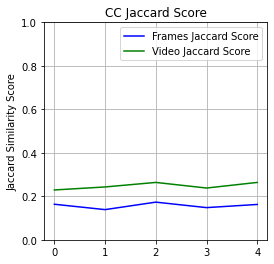

In [81]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.00, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='best')
plt.show()

In [100]:
videos_mean_jac_test

[0.1875,
 0.22916666666666663,
 0.26388888888888884,
 0.1597222222222222,
 0.2708333333333333]

In [ ]:
print(metrics.classification_report(y_test, Y_pred_chains, target_names=label_cols.tolist()))

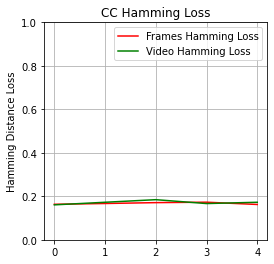

In [41]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, 1.0])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [113]:
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics

## MLTSVM is not compatible with later versions of numpy

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
col_indices = {i:label for (i,label) in enumerate(label_cols)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    print('%d-th split: train: %d, validation: %d' % (i+1, len(videos[train]), len(videos[test])))
    train_df = X_df[X_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', train_df.shape[0])
    y_train = train_df[label_cols].values
    X_train = train_df.drop(columns = cols_to_drop).values
    valid_df = X_df[X_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[label_cols].values
    X_valid = valid_df.drop(columns = cols_to_drop).values
    
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))

    # Predicting on test set
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    frames_mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    frames_mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

    # building test dataframe to vote labels
    test_result_df = None
    
    temp_df = pd.DataFrame(data=y_test_pred.toarray(), columns=label_cols)
    test_result_df = pd.concat([metadata_test, temp_df], axis=1)
    
    # print(test_result_df.head())
    video_groups = test_result_df.groupby('filename')[label_cols].apply(lambda x : x.astype(int).sum())
    # for name, group in video_groups:
    #     print(name)
    #     print(group)
    #     print("\n") 
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(test_df[test_df['filename'] == v].iloc[0][label_cols])
        num_1s = test_df[test_df['filename'] == v].iloc[0][label_cols].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)
        

1-th split: train: 56, validation: 14
Training+validation data size:  4053
Training data size:  4053
Validation data size:  1233
Validation Hamming Loss:
  0.16417564592747075
Test Hamming Loss:
  0.16406109613656783
Test Jaccard Score:
  0.17152890086852352
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
2-th split: train: 56, validation: 14
Training+validation data size:  4313
Training data size:  4313
Validation data size:  973
Validation Hamming Loss:
  0.1636323594185876
Test Hamming Loss:
  0.1559748427672956
Test Jaccard Score:
  0.21440551063192573
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
3-th split: train: 56, validation: 14
Training+validation data size:  4392
Training data size:  4392
Validation data size:  894
Validation Hamming Loss:
  0.19079578139980824
Test Hamming Loss:
  0.14627133872416892
Test Jaccard Score:
  0.22075471698113208
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
4-th split: train: 56, validation: 14


In [114]:
emotion_mapped_df = None
emotion_mapped_df = pd.DataFrame(columns=emotion_cols.tolist(), data=np.zeros((temp_df.shape[0], len(emotion_cols)), dtype=int))
emotion_mapped_df['filename'] = test_result_df['filename']
for emoji in label_cols.tolist():
    indices = temp_df[temp_df[emoji]==1].index
    emotions = na_emoji_map[emoji] # TODO: change to persian_emoji_map for persian
    # print(indices)
    # print(emotion)
    for emotion in emotions:
        emotion_mapped_df.at[indices.to_list(), emotion] = 1
emotion_video_groups = emotion_mapped_df.groupby('filename')[emotion_cols].sum()
ground_truth_video_emotions = []
for v in emotion_video_groups.index.to_list():
    ground_truth_video_emotions.append(test_df[test_df['filename'] == v].iloc[0][emotion_cols])
    num_1s = test_df[test_df['filename'] == v].iloc[0][emotion_cols].sum()
    num_1s = int(num_1s)
    a = np.argsort(emotion_video_groups.loc[v].values)
    for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
        emotion_video_groups.loc[v][a[i]] = 1
    for i in range(0, len(a) - num_1s):
        emotion_video_groups.loc[v][a[i]] = 0


## MLKNN - Categorizing emotions into emojis

In [115]:
print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(emotion_mapped_df.drop('filename', axis=1).values,  y_test_emotions.values, target_names=emotion_cols))
print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_emotions,  dtype=int),  emotion_video_groups.values, target_names=emotion_cols))

------------------- Frame-level F1 -----------------
              precision    recall  f1-score   support

        none       0.98      0.26      0.42       368
     furious       0.76      0.15      0.25       274
       anger       0.41      0.50      0.45       343
     annoyed       0.67      0.53      0.59       833
    contempt       0.40      0.12      0.18       704
     disgust       0.28      0.68      0.40       230
      hatred       0.00      0.00      0.00        17

   micro avg       0.50      0.36      0.41      2769
   macro avg       0.50      0.32      0.33      2769
weighted avg       0.58      0.36      0.39      2769
 samples avg       0.50      0.38      0.42      2769

------------------- Video-level F1 -----------------
              precision    recall  f1-score   support

        none       0.40      1.00      0.57         2
     furious       1.00      1.00      1.00         1
       anger       0.50      0.25      0.33         8
     annoyed       0.56   

In [119]:
print('------------------- Frame-level Jaccard -----------------')
print(metrics.jaccard_score(emotion_mapped_df.drop('filename', axis=1).values,  y_test_emotions.values, average='samples'))
print('------------------- Video-level Jaccard -----------------')
print(metrics.jaccard_score(np.array(ground_truth_video_emotions,  dtype=int),  emotion_video_groups.values, average='samples'))

------------------- Frame-level Jaccard -----------------
0.36048218029350104
------------------- Video-level Jaccard -----------------
0.38888888888888884


In [117]:
print('------------------- Frame-level F1 -----------------')
print(metrics.classification_report(y_test,  y_test_pred, target_names=label_cols.tolist()))

print('------------------- Video-level F1 -----------------')
print(metrics.classification_report(np.array(ground_truth_video_labels,  dtype=int),  emoji_video_groups.values, target_names=label_cols.tolist()))

------------------- Frame-level F1 -----------------
                precision    recall  f1-score   support

       neutral       0.00      0.00      0.00        72
         smirk       0.00      0.00      0.00         0
       furious       0.16      0.76      0.26        54
         weary       0.12      0.02      0.03       105
expressionless       0.54      0.43      0.48       537
      unamused       0.45      0.31      0.37       621
   rollingeyes       0.29      0.32      0.30       268
          none       0.39      0.60      0.47        99
     skeptical       0.00      0.00      0.00         0
         angry       0.49      0.11      0.18       375
     nauseated       0.20      0.13      0.16       193
      vomiting       0.39      0.21      0.27       263
       triumph       0.00      0.00      0.00         0
        hatred       0.00      0.00      0.00         0

     micro avg       0.31      0.28      0.29      2587
     macro avg       0.22      0.21      0.18    

In [118]:
print('------------------- Frame-level Jaccard -----------------')
print(metrics.jaccard_score(emotion_mapped_df.drop('filename', axis=1).values,  y_test_emotions.values, average='samples'))
print('------------------- Video-level Jaccard -----------------')
print(metrics.jaccard_score(np.array(ground_truth_video_emotions,  dtype=int),  emotion_video_groups.values, average='samples'))

------------------- Frame-level Jaccard -----------------
0.36048218029350104
------------------- Video-level Jaccard -----------------
0.38888888888888884


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, Y_pred_chains[-1], target_names=label_cols))

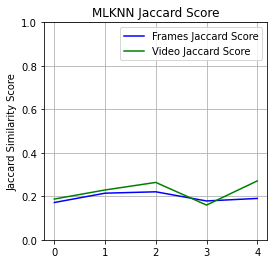

In [88]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.0, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='best')
plt.show()

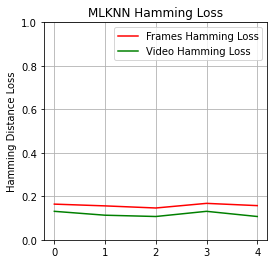

In [89]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, 1.])# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print(y_test[800:805])
print(metadata_test[800:805])

In [ ]:
print(len(y_test))
print(len(metadata_test))

In [ ]:
def clean(input: str):
    input = 'persian/' + input +".mp4"
    return input
X_df = pd.read_csv('../new_data/Persian/persian_dataset.csv', index_col=None)
X_df['filename'] = X_df['filename'].apply(clean)
X_df.to_csv('../new_data/Persian/persian_dataset.csv', index=False)